In [1]:
%pylab inline
import gc
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
import hmf
import haloSim
import simutil
from cosmology import Cosmo
cosmo   =   Cosmo(h=1.,omega_m=0.315)

from configparser import ConfigParser
from pixel3D import cartesianGrid3D
from scipy.interpolate import griddata
if False:
    figMsDir='/work/xiangchong.li/superonionGW/code/massMap_Private/doc/paper_ms_method_HSCY1/'
else:
    figMsDir='/home/xiangchong/Documents/Docs/massMap/paper_HSC2021/'
cmap=plt.get_cmap('tab20')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# h in Cosmo should be fixed to 1 (geometry fixed)
if False:
    cosmo   =   Cosmo(h=0.674,omega_m=0.315)
    v1=cosmo.V(zmin[iz],zmax[iz])
    rho1=cosmo.rho0()
    cosmo   =   Cosmo(h=1.,omega_m=0.315)
    v2=cosmo.V(zmin[iz],zmax[iz])
    rho2=cosmo.rho0()
    print(v1/v2*0.674**3.)
    print(rho1/rho2/0.674**2.)

In [3]:
# simply changing h change the hmf?
if False:
    mf = hmf.MassFunction(Mmin=14.,Mmax=14.1,dlog10m=0.05,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
    mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
    n1=mf.dndm
    mf = hmf.MassFunction(Mmin=14.,Mmax=14.1,dlog10m=0.05,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
    mf.update(cosmo_params={"Om0":0.315,"H0":100})
    n2=mf.dndm

In [4]:
configName  =   'wrkDir/config-nl8.ini'
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)
print(gridInfo.zlcgrid)
lensKer0=gridInfo.lensing_kernel(deltaIn=False)
zbound=gridInfo.zlbound
zave=gridInfo.zlcgrid

[0.0625 0.1075 0.1525 0.1975 0.2425 0.2875 0.3325 0.3775]


In [6]:
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=14.,Mmax=14.6,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>


7144
32846
64714
93231


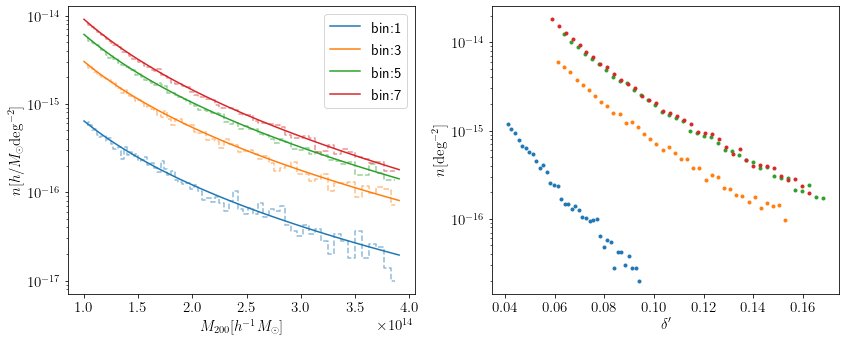

In [8]:
plt.close()
nscale=5e17
ngrid=64
fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

for iz in range(0,8,2):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi
    mf.update(z=z)
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m
    sAll=np.sum(mass_func)
    msample=[]
    nn=int(sAll*nscale)
    print(nn)
    imgList=np.empty((nn,ngrid,ngrid))
    for i in range(nn):
        mi=simutil.mcSample(m,mass_func)
        msample.append(mi)
        conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
        rs_arcmin=haloSim.mc2rs(mi,conc,z)
        imgList[i]=haloSim.haloCS02SigmaAtom(rs_arcmin,ngrid,ngrid,c=conc,smooth_scale=1.5,fou=False,lnorm=1)*mi/pix2mpc
    msample=np.array(msample)
    y=np.histogram(msample,bins=m)[0]
    ax1.plot(m,mass_func,label='bin:%d' %(iz+1),color=cmap(iz))
    ax1.step((mf.m[2:]+mf.m[1:-1])/2.,y[1:]/nscale,where='mid',color=cmap(iz),ls='--',alpha=0.5)
    
    selfnorm2=np.sqrt(np.sum(imgList**2,axis=(1,2)))
    haloAve=np.average(imgList,axis=0)
    norm=np.sqrt(np.sum(haloAve**2.))
    haloAve=haloAve/norm
    proj1=np.sum(imgList*haloAve[None,:,:],axis=(1,2))
    hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*proj1,bins=40)
    bave=(bounds[1:]+bounds[:-1])/2.
    ax2.scatter(bave[2:],hist[2:]/nscale,marker='.')
    del msample,imgList,hist,bounds
    gc.collect()
    
    
ax1.set_xlabel(r'$M_{200} [h^{-1}M_{\odot}]$')
ax1.set_ylabel(r'$n[h/M_{\odot}\rm{deg}^{-2}]$')
ax1.set_yscale('log')
ax1.legend()
ax2.set_xlabel(r"$\delta'$")
ax2.set_ylabel(r'$n[\rm{deg}^{-2}]$')
ax2.set_yscale('log')
plt.tight_layout()

$$\mathcal{L}(\{\gamma_{z_s,\vec{\theta}_s}\}| \{\alpha_{z_l,\vec{\theta}_l}\})
=\prod_{z_s,\vec{\theta}_s}\exp{\left(
\frac{\left(\gamma_{z_s,\vec{\theta}_s}-T_{z_s,z_l,\vec{\theta}_s,\vec{\theta}_l}\alpha_{z_l,\vec{\theta}_l}\right)^2}
{\sigma_{z_s,\vec{\theta}_s}}
\right)}$$
$$P(\{\alpha_{z_l,\vec{\theta}_l}\})=\prod_{z_l,\vec{\theta}_l}P(\alpha_{z_l,\vec{\theta}_l})$$

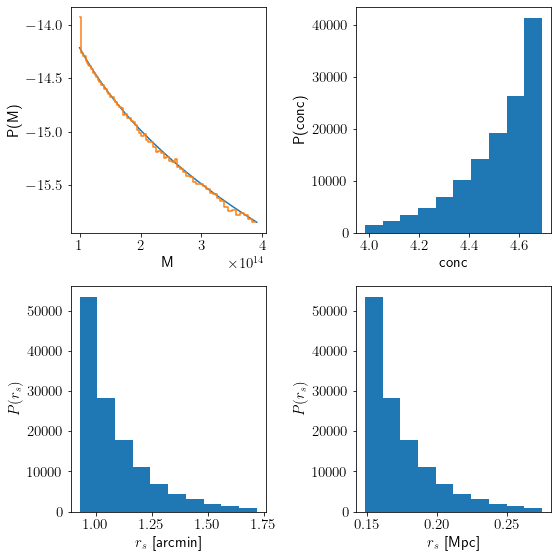

In [14]:
# One example redshift plane
iz=4
nscale=1e18
z=zave[iz]
mf.update(z=z)
v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
mass_func = mf.dndm*v
m = mf.m
msample=[]
sAll=np.sum(mass_func)
for i in range(int(sAll*nscale)):
    msample.append(simutil.mcSample(m,mass_func))
msample=np.array(msample)
conc =  6.02*(msample/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
rs_arcmin=haloSim.mc2rs(msample,conc,z)

# Plot
plt.close()
fig=plt.figure(figsize=(8,8))

ax=fig.add_subplot(2,2,1)
y=np.histogram(msample,bins=m)[0]
ax.plot(m,np.log10(mass_func/np.sum(mass_func)*sAll),label='bin:%d' %iz)
ax.step((mf.m[1:]+mf.m[:-1])/2.,np.log10(y/np.sum(y)*sAll),where='mid')
ax.set_xlabel('M')
ax.set_ylabel('P(M)')

ax=fig.add_subplot(2,2,2)
y=np.histogram(msample,bins=m)[0]
ax.hist(conc)
ax.set_xlabel('conc')
ax.set_ylabel('P(conc)')

ax=fig.add_subplot(2,2,3)
ax.hist(rs_arcmin)
ax.set_xlabel('$r_s$ [arcmin]')
ax.set_ylabel('$P(r_s)$')

ax=fig.add_subplot(2,2,4)
DaLens  =   cosmo.Da(0.,z) # angular distance in Mpc/h
arcmin2rad  =   np.pi/180./60.
rs       =   rs_arcmin*arcmin2rad* DaLens
ax.hist(rs)
ax.set_xlabel(r'$r_s$ [Mpc]')
ax.set_ylabel(r'$P(r_s)$')
plt.tight_layout()

907191053410107.2 118567920932576.69


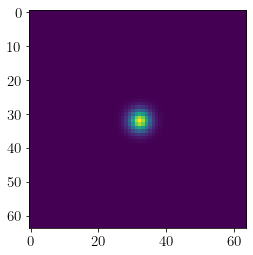

In [15]:
nn=5000
ngrid=64
imgList=np.empty((nn,ngrid,ngrid))
pix2mpc=cosmo.Da(0.,zave[iz])*1./60./180*np.pi
for i in range(nn):
    haloImg=haloSim.haloCS02SigmaAtom(rs_arcmin[i],ngrid,ngrid,c=conc[i],smooth_scale=1.5,fou=False,lnorm=1)*msample[i]/pix2mpc
    imgList[i]=haloImg
haloAve=np.average(imgList,axis=0)
imshow(np.fft.fftshift(haloAve))
print(np.sum(haloAve),np.sqrt(np.sum(haloAve**2.)))
norm=np.sqrt(np.sum(haloAve**2.))
haloAve=haloAve/norm

<ipython-input-16-ba755020d778>:7: RuntimeWarning: divide by zero encountered in log
  plt.scatter(bave[2:],np.log(hist[2:]),marker='.')


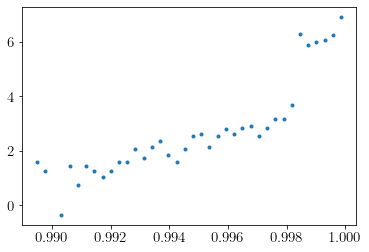

In [16]:
selfnorm1=np.sum(imgList,axis=(1,2))
selfnorm2=np.sqrt(np.sum(imgList**2,axis=(1,2)))
proj0=np.sum(imgList*haloAve[None,:,:],axis=(1,2))/selfnorm2
proj1=np.sum(imgList*haloAve[None,:,:],axis=(1,2))
hist,bounds=np.histogram(proj0,bins=40,density=True)
bave=(bounds[1:]+bounds[:-1])/2.
plt.scatter(bave[2:],np.log(hist[2:]),marker='.')

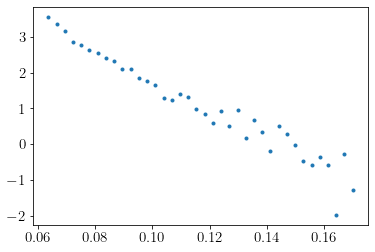

In [17]:
hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*selfnorm2,bins=40,density=True)
bave=(bounds[1:]+bounds[:-1])/2.
plt.scatter(bave[2:],np.log(hist[2:]),marker='.')

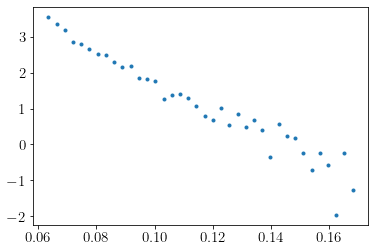

In [18]:
hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*proj1,bins=40,density=True)
bave=(bounds[1:]+bounds[:-1])/2.
plt.scatter(bave[2:],np.log(hist[2:]),marker='.')

In [35]:
pixG1=pyfits.getdata('wrkDir/test/g1Map-dempz.fits')
pixG2=pyfits.getdata('wrkDir/test/g2Map-dempz.fits')
pixStd=pyfits.getdata('wrkDir/test/stdMap-dempz.fits')

In [40]:
print(np.std(pixG1[pixStd>0.])*np.sqrt(2.))
print(np.average(pixStd[pixStd>0.]))

0.052384967669614015
0.04995704407369414
